#0.import and random seeds


In [1]:
import torch
import torch.nn as nn
import torch.distributions as td
import torch.utils.data
from tqdm import tqdm
from copy import deepcopy
import os
import math
import matplotlib.pyplot as plt
#dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)                           # Python built-in random module
    np.random.seed(seed)                        # NumPy random generator
    torch.manual_seed(seed)                     # PyTorch CPU random seed
    torch.cuda.manual_seed(seed)                # PyTorch current GPU random seed
    torch.cuda.manual_seed_all(seed)            # PyTorch all GPUs random seed
    torch.backends.cudnn.deterministic = True   # Ensure deterministic behavior in cuDNN
    torch.backends.cudnn.benchmark = False      # Disable auto-optimization to prevent non-deterministic behavior
    os.environ["PYTHONHASHSEED"] = str(seed)    # Control hash-based randomness in Python

set_seed(42)


#1.Dataset  
just copy the code provided by the professor



In [3]:
def subsample(data, targets, num_data, num_classes):
    idx = targets < num_classes  # Select samples with class labels less than num_classes (e.g., only classes 0, 1, 2)
    new_data = data[idx][:num_data].unsqueeze(1).to(torch.float32) / 255  # Select the first num_data images and normalize to [0,1]
    new_targets = targets[idx][:num_data]  # Select corresponding labels for the subsampled images
    return torch.utils.data.TensorDataset(new_data, new_targets)  # Create a TensorDataset with the filtered images and labels

num_train_data = 2048
num_classes = 3

train_tensors = datasets.MNIST(
    "data/", train=True, download=True,
    transform=transforms.Compose([transforms.ToTensor()])  # Convert images to tensors
)

test_tensors = datasets.MNIST(
    "data/", train=False, download=True,
    transform=transforms.Compose([transforms.ToTensor()])  # Convert images to tensors
)
train_data = subsample(
    train_tensors.data, train_tensors.targets,
    num_train_data, num_classes
)
test_data = subsample(
    test_tensors.data, test_tensors.targets,
    num_train_data, num_classes
)

batch_size=32
mnist_train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)
mnist_test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False
)
latent_dim=2
M=latent_dim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 9.91M/9.91M [00:11<00:00, 899kB/s] 
100%|██████████| 28.9k/28.9k [00:01<00:00, 26.8kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.13MB/s]


#2.GaussianPrior and Encoder/Decoder
Just copy the code provided by the professor


In [4]:
class GaussianPrior(nn.Module):
    def __init__(self, M):
        """
        Define a Gaussian prior distribution with zero mean and unit variance.

                Parameters:
        M: [int]
           Dimension of the latent space.
        """
        super(GaussianPrior, self).__init__()
        self.M = M
        self.mean = nn.Parameter(torch.zeros(self.M), requires_grad=False)
        self.std = nn.Parameter(torch.ones(self.M), requires_grad=False)

    def forward(self):
        """
        Return the prior distribution.

        Returns:
        prior: [torch.distributions.Distribution]
        """
        return td.Independent(td.Normal(loc=self.mean, scale=self.std), 1)

class GaussianEncoder(nn.Module):
    def __init__(self, encoder_net):
        """
        Define a Gaussian encoder distribution based on a given encoder network.

        Parameters:
        encoder_net: [torch.nn.Module]
            The encoder network that takes a tensor of dimension
            `(batch_size, feature_dim1, feature_dim2)` as input
            and outputs a tensor of dimension `(batch_size, 2M)`,
            where M is the dimension of the latent space.
        """
        super(GaussianEncoder, self).__init__()
        self.encoder_net = encoder_net

    def forward(self, x):
        """
        Given a batch of input data, return a Gaussian distribution over the latent space.

        Parameters:
        x: [torch.Tensor]
            A tensor of dimension `(batch_size, feature_dim1, feature_dim2)`.

        Returns:
        A Gaussian distribution with computed mean and standard deviation.
        """
        mean, std = torch.chunk(self.encoder_net(x), 2, dim=-1)
        return td.Independent(td.Normal(loc=mean, scale=torch.exp(std)), 1)

        # Example:
        # z = torch.randn(4, 10)  # Assume z is a tensor of shape [batch_size=4, 10]
        # a, b = torch.chunk(z, 2, dim=-1)
        # a and b will have shape [4, 5], as the tensor is split into two parts along the last dimension.
def new_encoder():
        encoder_net = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.Softmax(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.Softmax(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(512, 2 * M),
        )
        return encoder_net
class GaussianDecoder(nn.Module):
    def __init__(self, decoder_net):
        """
        Define a Gaussian decoder distribution based on a given decoder network.

        Parameters:
        decoder_net: [torch.nn.Module]
            The decoder network that takes a tensor of dimension `(batch_size, M)`
            as input, where M is the dimension of the latent space, and outputs a
            tensor of dimension `(batch_size, feature_dim1, feature_dim2)`.
        """
        super(GaussianDecoder, self).__init__()
        self.decoder_net = decoder_net
        # self.std = nn.Parameter(torch.ones(28, 28) * 0.5, requires_grad=True)
        # In case you want to learn the standard deviation of the Gaussian.

    def forward(self, z):
        """
        Given a batch of latent variables, return a Gaussian distribution over the data space.

        Parameters:
        z: [torch.Tensor]
            A tensor of dimension `(batch_size, M)`, where M is the dimension of the latent space.

        Returns:
        A Gaussian distribution with computed mean and a fixed standard deviation.
        """
        means = self.decoder_net(z)
        return td.Independent(td.Normal(loc=means, scale=1e-1), 3) #note the variance of decoder is fixed
        # This defines a 784-dimensional independent normal distribution, where each dimension is independent.
def new_decoder():
        decoder_net = nn.Sequential(
            nn.Linear(M, 512),
            nn.Unflatten(-1, (32, 4, 4)),
            nn.Softmax(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=0),
            nn.Softmax(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.Softmax(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
        )
        return decoder_net

#3.VAE
having changed the provided code ,so that for each mini-batch of data, we randomly sample a decoder and take a gradient step to optimize the ELBO


In [5]:
class VAE(nn.Module):
    def __init__(self, prior, decoders, encoder):
        """
        Variational Autoencoder (VAE) with multiple decoders.

        Parameters:
        prior: [torch.nn.Module]
            The prior distribution over the latent space.
        decoders: [list of torch.nn.Module]
            A list containing multiple decoders.
        encoder: [torch.nn.Module]
            The encoder network that maps input data to a latent distribution.
        """
        super(VAE, self).__init__()
        self.prior = prior
        self.decoders = nn.ModuleList(decoders)  # Use ModuleList to allow PyTorch to properly track parameters
        self.encoder = encoder

    def elbo(self, x, decoder_idx):
        """
        Compute the Evidence Lower Bound (ELBO) for a given input and selected decoder.

        Parameters:
        x: [torch.Tensor]
            The input data tensor.
        decoder_idx: [int]
            The index of the decoder to be used.

        Returns:
        The computed ELBO value.
        """
        q = self.encoder(x)  # Encode input into a latent distribution
        z = q.rsample()  # Sample from the latent distribution using the reparameterization trick
        decoder = self.decoders[decoder_idx]  # Select the corresponding decoder

        elbo = torch.mean(
            decoder(z).log_prob(x) - q.log_prob(z) + self.prior().log_prob(z)
        )  # Compute ELBO using the likelihood, posterior, and prior

        return elbo

    def sample(self, decoder_idx, n_samples=1):
        """
        Generate samples from the specified decoder.

        Parameters:
        decoder_idx: [int]
            The index of the decoder to be used.
        n_samples: [int, default=1]
            The number of samples to generate.

        Returns:
        A batch of generated samples.
        """
        z = self.prior().sample(torch.Size([n_samples]))  # Sample from the prior distribution
        decoder = self.decoders[decoder_idx]  # Select the corresponding decoder
        return decoder(z).sample()  # Generate samples from the decoder

    def forward(self, x, decoder_idx):
        """
        Compute the negative ELBO for optimization.

        Parameters:
        x: [torch.Tensor]
            The input data tensor.
        decoder_idx: [int]
            The index of the decoder to be used.

        Returns:
        The negative ELBO value.
        """
        return -self.elbo(x, decoder_idx)


#4.Training vae


In [6]:
def train(model, optimizers, data_loader, epochs, device):
    num_decoders = len(model.decoders)
    #one error
    # have changed the code to fit with different number of decoders
    total_epochs = epochs_per_decoder * num_decoders
    num_steps = len(data_loader) * total_epochs
    epoch = 0

    losses = []

    def noise(x, std=0.05):
        eps = std * torch.randn_like(x)
        return torch.clamp(x + eps, min=0.0, max=1.0)

    with tqdm(range(num_steps)) as pbar:
        for step in pbar:
            try:
                x = next(iter(data_loader))[0]
                x = noise(x.to(device))
                model=model
                idx = torch.randint(0, num_decoders, (1,)).item() #for each mini-batch of data, we randomly sample a decoder and take a gradient step to optimize the ELBO
                optimizer = optimizers[idx]
                optimizer.zero_grad()
                loss = model(x, decoder_idx=idx) #correspond to the changed part in VAE
                loss.backward()
                optimizer.step()

                loss_val = loss.detach().cpu().item()
                losses.append(loss_val)

                if step % 5 == 0:
                    pbar.set_description(
                        f"epoch={epoch}, step={step}, decoder={idx}, loss={loss_val:.1f}"
                    )
                if (step + 1) % len(data_loader) == 0:
                    epoch += 1
            except KeyboardInterrupt:
                print(f"Stopped at epoch {epoch}, step {step}, loss {loss_val:.1f}")
                break

    return losses


In [7]:
#because in part B we need 10 independent VAEs with  decoders 1,2,3, so I define a new train function
#S is the number of the decoders
def train_single_vae(seed, save_path, S, epochs_per_decoder):
    set_seed(seed)
    decoders = [GaussianDecoder(new_decoder()) for _ in range(S)]
    #instantiating  S randomly initialized decoders
    # note: set_seed(1001) only ensure the next time we run set_seed(1001), it's still the SAME randomly three decoders
    # it will not destroy of the randomness of three different decoders
    encoder = GaussianEncoder(new_encoder())
    prior = GaussianPrior(M)

    model = VAE(prior, decoders, encoder).to(device)
   # I just use the learning rate provided
    optimizers = [
        torch.optim.Adam(
            list(model.encoder.parameters()) + list(decoder.parameters()), lr=1e-3
        )
        for decoder in model.decoders
    ]

    losses = train(model, optimizers, mnist_train_loader, epochs_per_decoder, device)

    torch.save(model.state_dict(), save_path)
    plt.figure()
    plt.plot(range(5000, len(losses)), losses[5000:])
    plt.xlabel("Iteration")
    plt.ylabel("ELBO Loss")
    plt.title(f"Training Loss (Seed {seed}) [After 5000 Steps]")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path.replace(".pt", "_loss.png"))
    plt.close()


#5 train ONE VAE single and ensemble

In [8]:
# General training parameters
epochs_per_decoder = 400  # In fact, if I use 300–400 total epochs for 3-decoder VAE, the performance is not well
seed_base = 1000
num_vaes = 3

# Single decoder model
num_decoders_single = 1
experiments_folder_single = "experiments/vae_single"
os.makedirs(experiments_folder_single, exist_ok=True)  # Create directory if it doesn't exist

# Multiple decoder model
num_decoders_ensemble = 3
experiments_folder_ensemble = "experiments/vae_ensemble"
os.makedirs(experiments_folder_ensemble, exist_ok=True)  # Create directory if it doesn't exist

In [9]:
# Train single decoder model
for i in range(num_vaes):  # Can be expanded to train multiple VAE models
    seed = seed_base + i
    save_path = f"{experiments_folder_single}/sinmodel_seed{seed}.pt"
    print(f"Training SINGLE model with seed {seed}...")
    train_single_vae(seed, save_path, num_decoders_single, epochs_per_decoder)

Training SINGLE model with seed 1000...


  0%|          | 0/25600 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
epoch=399, step=25595, decoder=0, loss=32.3: 100%|██████████| 25600/25600 [03:21<00:00, 126.95it/s]


Training SINGLE model with seed 1001...


epoch=399, step=25595, decoder=0, loss=42.0: 100%|██████████| 25600/25600 [03:21<00:00, 127.32it/s]


Training SINGLE model with seed 1002...


epoch=399, step=25595, decoder=0, loss=-59.1: 100%|██████████| 25600/25600 [03:20<00:00, 127.58it/s]


In [10]:
# Train ensemble decoder model (one VAE with multiple decoders)
for i in range(num_vaes):  # Can be expanded to train multiple models
    seed = seed_base + i
    save_path = f"{experiments_folder_ensemble}/enmodel_seed{seed}.pt"
    print(f"Training ENSEMBLE model with seed {seed}...")
    train_single_vae(seed, save_path, num_decoders_ensemble, epochs_per_decoder)

Training ENSEMBLE model with seed 1000...


epoch=1199, step=76795, decoder=2, loss=-143.6: 100%|██████████| 76800/76800 [10:00<00:00, 127.84it/s]


Training ENSEMBLE model with seed 1001...


epoch=1199, step=76795, decoder=2, loss=48.9: 100%|██████████| 76800/76800 [10:03<00:00, 127.16it/s]


Training ENSEMBLE model with seed 1002...


epoch=1199, step=76795, decoder=2, loss=-235.8: 100%|██████████| 76800/76800 [10:03<00:00, 127.16it/s]


In [16]:
# After training, download the model_seed.pt, next time directly load the model

# Parameters
M = latent_dim
num_classes = 3

# Load single decoder models
vae_single_list = []
for i in range(num_vaes):
    seed = seed_base + i
    decoders_single = [GaussianDecoder(new_decoder())]
    encoder_single = GaussianEncoder(new_encoder())
    prior_single = GaussianPrior(M)
    vae_single = VAE(prior_single, decoders_single, encoder_single).to(device)
    vae_single.load_state_dict(torch.load(f"{experiments_folder_single}/sinmodel_seed{seed}.pt"))
    vae_single_list.append(vae_single)  # Store as vae_single_list[0], [1], [2] = vae_single1, 2, 3

# Load ensemble decoder models
vae_ensemble_list = []
for i in range(num_vaes):
    seed = seed_base + i
    decoders_ensemble = [GaussianDecoder(new_decoder()) for _ in range(num_decoders_ensemble)]
    encoder_ensemble = GaussianEncoder(new_encoder())
    prior_ensemble = GaussianPrior(M)
    vae_ensemble = VAE(prior_ensemble, decoders_ensemble, encoder_ensemble).to(device)
    vae_ensemble.load_state_dict(torch.load(f"{experiments_folder_ensemble}/enmodel_seed{seed}.pt"))
    vae_ensemble_list.append(vae_ensemble)  # Store as vae_ensemble_list[0], [1], [2] = vae_ensemble1, 2, 3

##5.1 latent space:
not relevant, just for checking whether the model encode the right latent space

In [17]:
def visualize_latent_space(model, dataloader, num_classes, save_path):
    model.eval()
    zs, labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            z = model.encoder(x).base_dist.loc
            zs.append(z.cpu())
            labels.append(y)
    zs = torch.cat(zs, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    plt.figure(figsize=(6, 6))
    for i in range(num_classes):
        idx = labels == i
        plt.scatter(zs[idx, 0], zs[idx, 1], s=5, alpha=0.6, label=f"Class {i}")
    plt.legend()
    plt.title("Latent Space")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()


In [18]:
# Visualize the latent space for each single decoder model
for i, vae_single in enumerate(vae_single_list):
    visualize_latent_space(
        vae_single,
        mnist_test_loader,
        num_classes=num_classes,
        save_path=f"latent_space_single_{i+1}.png"
    )

# Visualize the latent space for each ensemble decoder model
for i, vae_ensemble in enumerate(vae_ensemble_list):
    visualize_latent_space(
        vae_ensemble,
        mnist_test_loader,
        num_classes=num_classes,
        save_path=f"latent_space_ensemble_{i+1}.png"
    )


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


##5.2 sample
not relevant to this task, just for checking the quality of VAE


In [19]:
# === Single decoder outputs ===
experiments_single = "experiments/vae_single"
outputs_single = "experiments/vae_single_outputs"
os.makedirs(outputs_single, exist_ok=True)

for i, vae_single in enumerate(vae_single_list):
    seed = seed_base + i
    vae_single.eval()  # Set model to evaluation mode

    out_dir_single = f"{outputs_single}/vae_seed{seed}"
    os.makedirs(out_dir_single, exist_ok=True)

    with torch.no_grad():
        # Sampling (only one decoder)
        samples = vae_single.sample(decoder_idx=0, n_samples=64).cpu()
        save_image(samples.view(64, 1, 28, 28), f"{out_dir_single}/samples_decoder0.png")

        # Reconstruction
        data = next(iter(mnist_test_loader))[0].to(device)
        z = vae_single.encoder(data).mean
        recon = vae_single.decoders[0](z).mean
        save_image(
            torch.cat([data.cpu(), recon.cpu()], dim=0),
            f"{out_dir_single}/reconstruction_decoder0.png"
        )

In [20]:
# === Ensemble decoder outputs ===
outputs_ensemble = "experiments/vae_ensemble_outputs"
os.makedirs(outputs_ensemble, exist_ok=True)

for i, vae_ensemble in enumerate(vae_ensemble_list):
    seed = seed_base + i
    vae_ensemble.eval()

    out_dir_ensemble = f"{outputs_ensemble}/vae_seed{seed}"
    os.makedirs(out_dir_ensemble, exist_ok=True)

    with torch.no_grad():
        # Sampling from each decoder
        for j in range(num_decoders_ensemble):
            samples = vae_ensemble.sample(decoder_idx=j, n_samples=64).cpu()
            save_image(samples.view(64, 1, 28, 28), f"{out_dir_ensemble}/samples_decoder{j}.png")

        # Reconstruction using each decoder
        data = next(iter(mnist_test_loader))[0].to(device)
        z = vae_ensemble.encoder(data).mean
        for j in range(num_decoders_ensemble):
            recon = vae_ensemble.decoders[j](z).mean
            save_image(
                torch.cat([data.cpu(), recon.cpu()], dim=0),
                f"{out_dir_ensemble}/reconstruction_decoder{j}.png"
            )

##5.3 elbo not relevant to this task


In [ ]:
'''
num_vaes =1
experiments_folder = "experiments/vae_retrain_seeds"

for vae_idx in range(num_vaes):
    seed = 1000 + vae_idx
    model_path = f"{experiments_folder}/model_seed{seed}.pt"


    decoders = [GaussianDecoder(new_decoder()) for _ in range(num_decoders)]
    encoder = GaussianEncoder(new_encoder())
    prior = GaussianPrior(M)

    model = VAE(prior, decoders, encoder).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    elbos_per_decoder = [[] for _ in range(num_decoders)]

    with torch.no_grad():
        for x, _ in mnist_test_loader:
            x = x.to(device)
            for i in range(num_decoders):
                elbo = model.elbo(x, decoder_idx=i)
                elbos_per_decoder[i].append(elbo)


    print(f"\nVAE model with seed {seed}:")
    for i in range(num_decoders):
        mean_elbo = torch.tensor(elbos_per_decoder[i]).mean()
        print(f"  Decoder {i} mean test ELBO: {mean_elbo.item():.4f}")
'''


'\nnum_vaes =1\nexperiments_folder = "experiments/vae_retrain_seeds"\n\nfor vae_idx in range(num_vaes):\n    seed = 1000 + vae_idx\n    model_path = f"{experiments_folder}/model_seed{seed}.pt"\n\n    # 初始化结构（必须一致）\n    decoders = [GaussianDecoder(new_decoder()) for _ in range(num_decoders)]\n    encoder = GaussianEncoder(new_encoder())\n    prior = GaussianPrior(M)\n\n    model = VAE(prior, decoders, encoder).to(device)\n    model.load_state_dict(torch.load(model_path, map_location=device))\n    model.eval()\n\n    elbos_per_decoder = [[] for _ in range(num_decoders)]\n\n    with torch.no_grad():\n        for x, _ in mnist_test_loader:\n            x = x.to(device)\n            for i in range(num_decoders):\n                elbo = model.elbo(x, decoder_idx=i)\n                elbos_per_decoder[i].append(elbo)\n\n    # 输出每个 decoder 的 mean ELBO\n    print(f"\nVAE model with seed {seed}:")\n    for i in range(num_decoders):\n        mean_elbo = torch.tensor(elbos_per_decoder[i]).mean()\n 

#6 cruve and energy


##6.1 cubiccurve


In [21]:
class CubicCurve(nn.Module):
    def __init__(self, c0, c1):
        """
        Parameters:
        c0: torch.Tensor, start point (D,)
        c1: torch.Tensor, end point (D,)
        """
        super().__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Use GPU if available
        self.T = 128  # Number of segments
        self.D = c0.shape[0]  # Dimensionality of the curve

        self.register_buffer("c0", c0.to(self.device))  # Register start point as buffer (not trainable)
        self.register_buffer("c1", c1.to(self.device))  # Register end point as buffer (not trainable)

        # Initialize intermediate control points to form a straight line between c0 and c1
        # This ensures the initial curve is a straight line before optimization
        intermediate_points = torch.stack([
            c0 + (c1 - c0) * (i + 1) / self.T  # Equally spaced points along the line from c0 to c1
            for i in range(self.T - 1)
        ], dim=0).to(self.device)  # Shape: (T-1, D)

        self.c_t = nn.Parameter(intermediate_points)  # Make intermediate control points trainable

        # Create a uniform grid of time values from 0 to 1 with T+1 points
        self.register_buffer("t_grid", torch.linspace(0, 1, self.T + 1, device=self.device))

    def forward(self, t):
        """
        Compute the value of the piecewise linear curve at position t

        Parameters:
        t: torch.Tensor, shape (...,), range [0,1]

        Returns:
        torch.Tensor, shape (...,D)

        Each segment is linearly interpolated between two control points:
        Given control points p0 and p1, and a scalar alpha ∈ [0, 1],
        interpolation formula is: p(t) = (1 - alpha) * p0 + alpha * p1
        where alpha = (t - t0) / (t1 - t0)
        """
        t = t.to(self.device)  # Ensure t is on the correct device

        # Concatenate all control points: [c0, ..., c_t, ..., c1], shape (T+1, D)
        control_points = torch.cat([self.c0.unsqueeze(0), self.c_t, self.c1.unsqueeze(0)], dim=0)

        # For each t, find the corresponding segment index in t_grid
        idx = torch.searchsorted(self.t_grid, t, right=True) - 1  # Get left index of segment
        idx = idx.clamp(0, self.T - 1)  # Clamp to valid range

        # Get start and end times of the segment
        t0, t1 = self.t_grid[idx], self.t_grid[idx + 1]

        # Compute alpha for interpolation within the segment
        alpha = (t - t0) / (t1 - t0 + 1e-8)  # Normalize t within [t0, t1]

        # Get the corresponding control points
        c0, c1 = control_points[idx], control_points[idx + 1]

        # Perform linear interpolation:
        # p(t) = (1 - alpha) * c0 + alpha * c1
        # This is derived from:
        # If t ∈ [t_i, t_{i+1}], then:
        #     p(t) = c_i + (c_{i+1} - c_i) * (t - t_i) / (t_{i+1} - t_i)
        #          = (1 - alpha) * c_i + alpha * c_{i+1}
        return (1 - alpha.unsqueeze(-1)) * c0 + alpha.unsqueeze(-1) * c1  # (...,D)


In [22]:

# Create start and end points
c0 = torch.tensor([0.0, 0.0])
c1 = torch.tensor([1.0, 1.0])

# Instantiate the curve object
curve = CubicCurve(c0, c1)

# Example t values (must be in the range [0,1])
t_sample = torch.tensor([0.0, 0.1, 0.5, 0.9, 1.0])

# Compute corresponding values on the curve
curve_values = curve(t_sample)

print("t_sample shape:", t_sample.shape)  # Shape of input t
print("curve_values shape:", curve_values.shape)  # Shape of output curve values
print("curve_values content:", curve_values)  # Output values at the sampled t positions


t_sample shape: torch.Size([5])
curve_values shape: torch.Size([5, 2])
curve_values content: tensor([[0.0000, 0.0000],
        [0.1000, 0.1000],
        [0.5000, 0.5000],
        [0.9000, 0.9000],
        [1.0000, 1.0000]], device='cuda:0', grad_fn=<AddBackward0>)


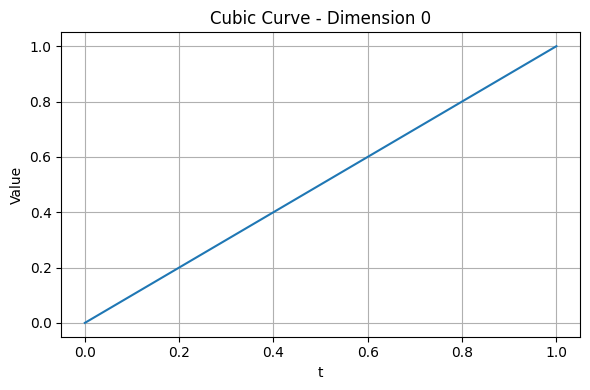

In [23]:

# Create start and end points
c0 = torch.tensor([0.0, 0.0])
c1 = torch.tensor([1.0, 1.0])

# Initialize the curve object
curve = CubicCurve(c0, c1)

# Sample t values uniformly from 0 to 1
t_vals = torch.linspace(0, 1, 256)

# Compute curve points without gradient tracking
with torch.no_grad():
    points = curve(t_vals)  # Shape: (256, 2)

# Extract dimension 0 and move to CPU
y_vals = points[:, 0].cpu()

# Plot the curve for dimension 0 as a function of t
plt.figure(figsize=(6, 4))
plt.plot(t_vals.cpu(), y_vals, label='Dim 0')
plt.title("Cubic Curve - Dimension 0")
plt.xlabel("t")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()


##6.2 compute_energy

$$
\mathcal{E}[\gamma] \approx \sum_{t=0}^{T-1} \mathbb{E}_{\theta, \theta' \sim q(\theta) q(\theta)}
\left[ \left\| f_{\theta} (\gamma(t + \frac{1}{T})) - f_{\theta'} (\gamma(t / T)) \right\|^2 \right]
$$

$f_{\theta}$ $f_{\theta'}$ denotes deoder ensemble members drawn uniformly

In [ ]:
def compute_curve_energy(curve, decoders, T=16, num_samples=1, fixed_indices=None, device='cuda'):
    """
    Compute the energy of a curve using fixed decoder indices to ensure the objective function remains consistent.

    Parameters:
    - curve: An instance of CubicCurve
    - decoders: List of decoder modules
    - T: Number of time steps, default is 16
    - num_samples: Number of Monte Carlo samples, default is 1
    - fixed_indices: Pre-fixed decoder indices [(idx1_t0, idx2_t0), (idx1_t1, idx2_t1), ...]
    - device: Computing device, default is 'cuda'

    Returns:
    - Scalar energy value
    """
    total_energy = 0.0  # Accumulate energy over all time steps

    for i in range(T):
        t0 = torch.tensor([i / T], device=device, dtype=torch.float32)
        t1 = torch.tensor([(i + 1) / T], device=device, dtype=torch.float32)

        x0 = curve(t0)  # γ(t0), shape [1, d]
        x1 = curve(t1)  # γ(t1)

        energy = 0.0  # Energy for the current time step

        for _ in range(num_samples):
            idx1, idx2 = fixed_indices[i]  # Retrieve fixed indices

            # **Compute only the required decoder outputs**
            sampled_mean_x0 = decoders[idx1](x0).mean  # Directly compute the mean for idx1
            sampled_mean_x1 = decoders[idx2](x1).mean  # Directly compute the mean for idx2

            # Compute L2 norm
            energy += torch.norm(sampled_mean_x1 - sampled_mean_x0, p=2)

        # Take Monte Carlo average, negligible when num_samples = 1
        total_energy += energy / num_samples

    return total_energy  # Return total energy


##6.3 optimize_geodesics

In [ ]:
def optimize_geodesic(c0, c1, decoders, T=16, steps=500, lr=1e-2, device='cuda',
                      early_stopping_n=100, early_stopping_delta=1e-4):
    """
    Optimize a geodesic curve while ensuring the objective function remains unchanged during optimization.

    Parameters:
    - c0: Starting point
    - c1: Endpoint
    - decoders: List of decoder modules
    - T: Number of time steps
    - steps: Number of optimization iterations
    - lr: Learning rate
    - device: Computing device
    - early_stopping_n: Number of steps to check for early stopping
    - early_stopping_delta: Minimum required improvement to continue

    Returns:
    - Optimized curve
    - Logged energy values
    """
    curve = CubicCurve(c0, c1).to(device)  # Initialize the curve
    optimizer = torch.optim.Adam(curve.parameters(), lr=lr)  # Adam optimizer
    energy_log = []  # Store energy values

    # **Pre-generate fixed decoder indices**
    fixed_indices = [(torch.randint(0, len(decoders), (1,), device=device).item(),
                      torch.randint(0, len(decoders), (1,), device=device).item())
                     for _ in range(T)]

    best_energy = float('inf')
    no_improve_count = 0  # Counter for early stopping

    with tqdm(range(steps)) as pbar:
        for step in pbar:
            optimizer.zero_grad()  # Clear gradients
            energy = compute_curve_energy(curve, decoders, T=T, fixed_indices=fixed_indices, device=device)  # Compute energy
            energy.backward()  # Backpropagation
            optimizer.step()  # Update parameters

            energy_value = energy.item()
            energy_log.append(energy_value)  # Store energy value

            # Early Stopping Logic
            if energy_value < best_energy - early_stopping_delta:
                best_energy = energy_value
                no_improve_count = 0  # Reset counter
            else:
                no_improve_count += 1

            if no_improve_count >= early_stopping_n:
                print(f"Early stopping at step {step}, energy: {energy_value:.6f}")
                break  # Stop training if no improvement

            # Update progress bar
            pbar.set_description(f"Energy: {energy_value:.6f}")

    return curve, energy_log


#7.plot  25 random latent_varibale pairs


##7.1 data preparation

In [ ]:
num_pairs = 5  # Number of image pairs, for testing use 5, should use 25 in full runs

# ====== Extract All Test Images ======
test_images = []
test_labels = []
for x, y in mnist_test_loader:
    test_images.append(x)
    test_labels.append(y)
test_images = torch.cat(test_images, dim=0)  # Shape: [N, 1, 28, 28]
test_labels = torch.cat(test_labels, dim=0)

# ====== Randomly Sample Image Pairs ======
N = test_images.shape[0]
indices = random.sample(range(N), 2 * num_pairs)  # Sample 2 * num_pairs indices
x_pairs = torch.stack([
    torch.stack([test_images[indices[i]], test_images[indices[i + 1]]], dim=0)
    for i in range(0, 2 * num_pairs, 2)
])  # Shape: [num_pairs, 2, 1, 28, 28]

# ====== Encode Image Pairs into Latent Space ======
z_pairs_single_list = []     # Each element corresponds to one VAE (single)
z_pairs_ensemble_list = []   # Each element corresponds to one VAE (ensemble)

# Process all single decoder VAEs
for vae_single in vae_single_list:
    vae_single.eval()
    z_pairs = []
    with torch.no_grad():
        for i in range(num_pairs):
            x0 = x_pairs[i, 0].to(device)
            x1 = x_pairs[i, 1].to(device)
            z0 = vae_single.encoder(x0.unsqueeze(0)).base_dist.loc.squeeze(0)
            z1 = vae_single.encoder(x1.unsqueeze(0)).base_dist.loc.squeeze(0)
            z_pairs.append(torch.stack([z0, z1], dim=0))
    z_pairs_single_list.append(torch.stack(z_pairs))  # Shape: [num_pairs, 2, latent_dim]

# Process all ensemble decoder VAEs
for vae_ensemble in vae_ensemble_list:
    vae_ensemble.eval()
    z_pairs = []
    with torch.no_grad():
        for i in range(num_pairs):
            x0 = x_pairs[i, 0].to(device)
            x1 = x_pairs[i, 1].to(device)
            z0 = vae_ensemble.encoder(x0.unsqueeze(0)).base_dist.loc.squeeze(0)
            z1 = vae_ensemble.encoder(x1.unsqueeze(0)).base_dist.loc.squeeze(0)
            z_pairs.append(torch.stack([z0, z1], dim=0))
    z_pairs_ensemble_list.append(torch.stack(z_pairs))  # Shape: [num_pairs, 2, latent_dim]


In [ ]:
# ====== Parameter Settings ======
T = 128  # Number of segments for energy calculation,T=20, maybe too small? but too large require longer time
steps = 2000  # Number of optimization iterations, some points still don't decrease,maybe we should use early stopping
lr = 5*1e-3 # Learning rate or should it be tuned larger?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device

In [ ]:
'''
curves_single = []
energy_logs_single = []

for i in range(num_pairs):
    c0, c1 = z_pairs_single[i, 0].to(device), z_pairs_single[i, 1].to(device)
    curve, energy_log = optimize_geodesic(c0, c1,
                                          decoders=[vae_single.decoders[0]],  # only use one decoder
                                          T=T,
                                          steps=steps,
                                          lr=lr,
                                          device=device,
                                          early_stopping_n=50,  # patience
                                          early_stopping_delta=1e-3)

    curves_single.append(curve)  # the curev after optimizing
    energy_logs_single.append(energy_log)
'''

Energy: 16.435904:   7%|▋         | 137/2000 [01:30<20:30,  1.51it/s]


Early stopping at step 137, energy: 16.435812


Energy: 14.798503:  10%|█         | 210/2000 [02:17<19:30,  1.53it/s]


Early stopping at step 210, energy: 14.798399


Energy: 8.002676:   2%|▎         | 50/2000 [00:33<21:30,  1.51it/s]


Early stopping at step 50, energy: 8.002597


Energy: 17.474449:  93%|█████████▎| 1853/2000 [20:07<01:35,  1.54it/s]

Early stopping at step 1853, energy: 17.474434


In [ ]:
os.makedirs('results_single', exist_ok=True)  # Create base directory if it doesn't exist

all_curves_single = []         # List to store curve lists per model
all_energy_logs_single = []    # List to store energy log lists per model

for model_idx, z_pairs_single in enumerate(z_pairs_single_list):  # Loop over all single decoder models
    curves_single = []        # Curves for this model
    energy_logs_single = []   # Energy logs for this model

    model_result_dir = f'results_single/model_{model_idx+1}'
    os.makedirs(model_result_dir, exist_ok=True)

    for i in range(num_pairs):
        curve_path = f'{model_result_dir}/curve_single_{i+1}.pt'       # Path to save/load curve
        energy_log_path = f'{model_result_dir}/energylog_single_{i+1}.pt'  # Path to save/load energy log

        if os.path.exists(curve_path) and os.path.exists(energy_log_path):
            # Load from existing files
            loaded_curve = torch.load(curve_path, map_location=device, weights_only=False)
            loaded_energy_log = torch.load(energy_log_path, map_location=device, weights_only=False)
        else:
            # Optimize and save
            c0, c1 = z_pairs_single[i, 0].to(device), z_pairs_single[i, 1].to(device)
            loaded_curve, loaded_energy_log = optimize_geodesic(
                c0, c1,
                decoders=[vae_single_list[model_idx].decoders[0]],  # Use decoder 0 from this model
                T=T,
                steps=steps,
                lr=lr,
                device=device,
                early_stopping_n=50,
                early_stopping_delta=1e-3
            )
            torch.save(loaded_curve, curve_path)
            torch.save(loaded_energy_log, energy_log_path)

        curves_single.append(loaded_curve)
        energy_logs_single.append(loaded_energy_log)

    all_curves_single.append(curves_single)
    all_energy_logs_single.append(energy_logs_single)


  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Energy: 8.004173:   2%|▎         | 50/2000 [00:33<21:50,  1.49it/s]


Early stopping at step 50, energy: 8.004137


Energy: 22.798315:  10%|▉         | 198/2000 [02:08<19:33,  1.54it/s]


KeyboardInterrupt: 

In fact,different points has different decreasing covergence speed, so I guess we can use early stopping, setting max=5000, if within patience=50 steps , the energy is basically the same, then early stop.

just refer to the orginial paper (also use early stopping)
https://github.com/mustass/ensertainty/blob/main/configs/inference/ensemble_geodesics.yaml

In [ ]:
T = 128
steps = 200
lr = 5 * 1e-2

os.makedirs('results_ensemble', exist_ok=True)  # Base directory

all_curves_ensemble = []         # List to store curves per ensemble model
all_energy_logs_ensemble = []    # List to store energy logs per ensemble model

for model_idx, z_pairs_ensemble in enumerate(z_pairs_ensemble_list):  # Loop over all ensemble models
    curves_ensemble = []        # Curves for this model
    energy_logs_ensemble = []   # Energy logs for this model

    model_result_dir = f'results_ensemble/model_{model_idx+1}'
    os.makedirs(model_result_dir, exist_ok=True)

    for i in range(num_pairs):
        curve_path = f'{model_result_dir}/curve_ensemble_{i+1}.pt'
        energy_log_path = f'{model_result_dir}/energylog_ensemble_{i+1}.pt'

        if os.path.exists(curve_path) and os.path.exists(energy_log_path):
            # Load existing results
            loaded_curve = torch.load(curve_path, map_location=device, weights_only=False)
            loaded_energy_log = torch.load(energy_log_path, map_location=device, weights_only=False)
        else:
            # Run optimization and save
            c0, c1 = z_pairs_ensemble[i, 0].to(device), z_pairs_ensemble[i, 1].to(device)
            loaded_curve, loaded_energy_log = optimize_geodesic(
                c0, c1,
                decoders=vae_ensemble_list[model_idx].decoders,
                T=T,
                steps=steps,
                lr=lr,
                device=device,
                early_stopping_n=50,
                early_stopping_delta=1e-3
            )
            torch.save(loaded_curve, curve_path)
            torch.save(loaded_energy_log, energy_log_path)

        curves_ensemble.append(loaded_curve)
        energy_logs_ensemble.append(loaded_energy_log)

    all_curves_ensemble.append(curves_ensemble)
    all_energy_logs_ensemble.append(energy_logs_ensemble)


  0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Energy: 84.366440:  14%|█▍        | 29/200 [00:19<01:53,  1.51it/s]


KeyboardInterrupt: 

## 7.2 plot the energy curve
testing the optimizer

In [ ]:
def plot_energy_logs_per_pair(energy_logs, decoder_count, model_idx, base_folder="energy_logs"):
    """
    Plot the energy variation curve for each pair of points and save them in separate folders per model.

    Parameters:
    - energy_logs: List of energy logs for one model (list of length num_pairs).
    - decoder_count: int, number of decoders used in the model (1 or >1).
    - model_idx: int, index of the current model (starting from 0).
    - base_folder: str, root directory for saving the plots.
    """
    folder = os.path.join(base_folder, f"vae_d{decoder_count}", f"model_{model_idx+1}")
    os.makedirs(folder, exist_ok=True)

    for pair_idx, log in enumerate(energy_logs):
        plt.figure(figsize=(8, 6))
        plt.plot(log)
        plt.xlabel("Optimization Step")
        plt.ylabel("Energy")
        plt.title(f"Geodesic Energy (Decoder={decoder_count}, Model={model_idx+1}, Pair={pair_idx})")
        plt.grid(True)
        plt.tight_layout()

        save_path = os.path.join(folder, f"pair_{pair_idx}.png")
        plt.savefig(save_path, dpi=300)
        plt.close()






In [ ]:
# Plot for all single decoder models
for model_idx, energy_logs in enumerate(all_energy_logs_single):
    plot_energy_logs_per_pair(energy_logs, decoder_count=1, model_idx=model_idx)

In [ ]:
# Plot for all ensemble decoder models
for model_idx, energy_logs in enumerate(all_energy_logs_ensemble):
    plot_energy_logs_per_pair(energy_logs, decoder_count=3, model_idx=model_idx)

##7.3 plot the required comparision plot of geodesics

In [ ]:
# ====== Encode all test data for all models ======
def encode_all_test_latents(model):
    """
    Encode the entire test dataset into the latent space.

    Parameters:
    - model: VAE model (single or ensemble) used for encoding.

    Returns:
    - zs: Tensor of latent representations.
    - ys: Corresponding labels.
    """
    zs, ys = [], []
    with torch.no_grad():
        for x, y in mnist_test_loader:
            x = x.to(device)
            q = model.encoder(x)
            z = q.base_dist.loc
            zs.append(z.cpu())
            ys.append(y)
    return torch.cat(zs, dim=0), torch.cat(ys, dim=0)

# Encode full test set for each model
latents_single = [encode_all_test_latents(model) for model in vae_single_list]
latents_ensemble = [encode_all_test_latents(model) for model in vae_ensemble_list]

In [ ]:
# ====== Plotting geodesics ======
sample_steps = 256

def plot_geodesics(latent_z, labels, z_pairs, curves, title, out_path):
    """
    Plot geodesic paths in the latent space.

    Parameters:
    - latent_z: Latent representations of the test dataset.
    - labels: Corresponding labels.
    - z_pairs: Latent point pairs.
    - curves: Geodesic curves (list of callables).
    - title: Plot title.
    - out_path: File path to save the plot.
    """
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_z[:, 0], latent_z[:, 1], c=labels, cmap="tab10", s=8, alpha=0.4)
    t_vals = torch.linspace(0, 1, sample_steps).to(device)

    colors = ['r', 'g', 'b', 'm', 'c', 'y', 'orange', 'purple', 'gray', 'lime']

    for i in range(len(curves)):
        gamma = curves[i](t_vals).detach().cpu()
        c0, c1 = z_pairs[i, 0], z_pairs[i, 1]
        color = colors[i % len(colors)]
        plt.plot(gamma[:, 0], gamma[:, 1], color=color, linewidth=1.5, label=f'Geodesic {i}')
        plt.plot([c0[0], c1[0]], [c0[1], c1[1]], 'k--', linewidth=0.8)

    plt.title(title)
    plt.xlabel("z1")
    plt.ylabel("z2")
    plt.grid(True)
    plt.legend(title="Class & Geodesics", loc="best")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.close()

In [ ]:
# ====== Generate plots for all models ======
for i in range(len(vae_single_list)):
    z, y = latents_single[i]
    plot_geodesics(
        latent_z=z,
        labels=y,
        z_pairs=z_pairs_single_list[i].cpu(),
        curves=all_curves_single[i],
        title=f"Geodesics in Latent Space (Single Decoder {i+1})",
        out_path=f"vae_single_geodesics_{i+1}.png"
    )


In [ ]:

for i in range(len(vae_ensemble_list)):
    z, y = latents_ensemble[i]
    plot_geodesics(
        latent_z=z,
        labels=y,
        z_pairs=z_pairs_ensemble_list[i].cpu(),
        curves=all_curves_ensemble[i],
        title=f"Geodesics in Latent Space (Ensemble Decoder {i+1})",
        out_path=f"vae_ensemble_geodesics_{i+1}.png"
    )